In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [4]:
class AODnet(nn.Module):
    def __init__(self):
        super(AODnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, stride=1, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.b = 1

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3), 1)
        x4 = F.relu(self.conv4(cat2))
        cat3 = torch.cat((x1, x2, x3, x4), 1)
        k = F.relu(self.conv5(cat3))

        if k.size() != x.size():
            raise Exception("k, haze image are different size!")

        output = k * x - k + self.b
        return F.relu(output)

class PONO(nn.Module):
    def __init__(self, input_size=None, return_stats=False, affine=True, eps=1e-5):
        super(PONO, self).__init__()
        self.return_stats = return_stats
        self.input_size = input_size
        self.eps = eps
        self.affine = affine
        if affine:
            self.beta = nn.Parameter(torch.zeros(1, 1, *input_size)) if input_size is not None else None
            self.gamma = nn.Parameter(torch.ones(1, 1, *input_size)) if input_size is not None else None
        else:
            self.beta, self.gamma = None, None
    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = (x.var(dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        if self.affine:
            x = x * self.gamma + self.beta
        return x, mean, std

class MS(nn.Module):
    def __init__(self, beta=None, gamma=None):
        super(MS, self).__init__()
        self.gamma, self.beta = gamma, beta

    def forward(self, x, beta=None, gamma=None):
        beta = self.beta if beta is None else beta
        gamma = self.gamma if gamma is None else gamma
        if gamma is not None:
            x = x * gamma  # ★★★ 수정된 부분 ★★★
        if beta is not None:
            x = x + beta   # ★★★ 수정된 부분 ★★★
        return x

class AOD_pono_net(nn.Module):
    def __init__(self):
        super(AOD_pono_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, stride=1, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.b = 1
        self.pono = PONO(affine=False)
        self.ms = MS()
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x1, mean1, std1 = self.pono(x1)
        x2, mean2, std2 = self.pono(x2)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3), 1)
        x3 = self.ms(x3, mean1, std1)
        x4 = F.relu(self.conv4(cat2))
        x4 = self.ms(x4, mean2, std2)
        cat3 = torch.cat((x1, x2, x3, x4), 1)
        k = F.relu(self.conv5(cat3))
        if k.size() != x.size():
            raise Exception("k, haze image are different size!")
        output = k * x - k + self.b
        return F.relu(output)

In [16]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
aod_model = AODnet()
print_model_summary(aod_model, "AODnet")

# 2. AOD_pono_net 모델 객체 생성 및 파라미터 확인
# PONO의 affine=False이므로 추가 파라미터가 없습니다.
aod_pono_model = AOD_pono_net()
print_model_summary(aod_pono_model, "AOD_pono_net")

========== AODnet Summary ==========
Layer: conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: conv1.bias,  Shape: torch.Size([3])
Layer: conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: conv2.bias,  Shape: torch.Size([3])
Layer: conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: conv3.bias,  Shape: torch.Size([3])
Layer: conv4.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: conv4.bias,  Shape: torch.Size([3])
Layer: conv5.weight,  Shape: torch.Size([3, 12, 3, 3])
Layer: conv5.bias,  Shape: torch.Size([3])

Total trainable parameters: 1,761


========== AOD_pono_net Summary ==========
Layer: conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: conv1.bias,  Shape: torch.Size([3])
Layer: conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: conv2.bias,  Shape: torch.Size([3])
Layer: conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: conv3.bias,  Shape: torch.Size([3])
Layer: conv4.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: conv4.bias,  Shape: torch.Size([3])
Layer: co

In [17]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [18]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [19]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((360, 240)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 360, 240])
GT 이미지 텐서 모양: torch.Size([3, 360, 240])


In [20]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AOD_pono_net().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Model: AOD_pono_net


In [21]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.73it/s, loss=0.00828]


Epoch [1/100], Train Loss: 0.163902, Val Loss: 0.030042
***** Best model saved to ./pt\best_model_epoch_1.pth (Val Loss: 0.030042) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.79it/s, loss=0.00939]


Epoch [2/100], Train Loss: 0.026581, Val Loss: 0.025627
***** Best model saved to ./pt\best_model_epoch_2.pth (Val Loss: 0.025627) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.19it/s, loss=0.0084] 


Epoch [3/100], Train Loss: 0.025785, Val Loss: 0.025288
***** Best model saved to ./pt\best_model_epoch_3.pth (Val Loss: 0.025288) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.95it/s, loss=0.00928]


Epoch [4/100], Train Loss: 0.025520, Val Loss: 0.025108
***** Best model saved to ./pt\best_model_epoch_4.pth (Val Loss: 0.025108) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s, loss=0.0089] 


Epoch [5/100], Train Loss: 0.025370, Val Loss: 0.024933
***** Best model saved to ./pt\best_model_epoch_5.pth (Val Loss: 0.024933) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s, loss=0.00808]


Epoch [6/100], Train Loss: 0.025250, Val Loss: 0.024827
***** Best model saved to ./pt\best_model_epoch_6.pth (Val Loss: 0.024827) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s, loss=0.00809]


Epoch [7/100], Train Loss: 0.025193, Val Loss: 0.024722
***** Best model saved to ./pt\best_model_epoch_7.pth (Val Loss: 0.024722) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.97it/s, loss=0.00932]


Epoch [8/100], Train Loss: 0.025105, Val Loss: 0.024717
***** Best model saved to ./pt\best_model_epoch_8.pth (Val Loss: 0.024717) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.94it/s, loss=0.00879]


Epoch [9/100], Train Loss: 0.024999, Val Loss: 0.024529
***** Best model saved to ./pt\best_model_epoch_9.pth (Val Loss: 0.024529) *****



Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.84it/s, loss=0.008]  


Epoch [10/100], Train Loss: 0.024807, Val Loss: 0.024384
***** Best model saved to ./pt\best_model_epoch_10.pth (Val Loss: 0.024384) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s, loss=0.00829]


Epoch [11/100], Train Loss: 0.024671, Val Loss: 0.024235
***** Best model saved to ./pt\best_model_epoch_11.pth (Val Loss: 0.024235) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s, loss=0.0079] 


Epoch [12/100], Train Loss: 0.024501, Val Loss: 0.024102
***** Best model saved to ./pt\best_model_epoch_12.pth (Val Loss: 0.024102) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s, loss=0.00811]


Epoch [13/100], Train Loss: 0.024401, Val Loss: 0.023936
***** Best model saved to ./pt\best_model_epoch_13.pth (Val Loss: 0.023936) *****



Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.93it/s, loss=0.0082] 


Epoch [14/100], Train Loss: 0.024220, Val Loss: 0.023817
***** Best model saved to ./pt\best_model_epoch_14.pth (Val Loss: 0.023817) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.24it/s, loss=0.00988]


Epoch [15/100], Train Loss: 0.023844, Val Loss: 0.023267
***** Best model saved to ./pt\best_model_epoch_15.pth (Val Loss: 0.023267) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s, loss=0.00898]


Epoch [16/100], Train Loss: 0.022816, Val Loss: 0.022186
***** Best model saved to ./pt\best_model_epoch_16.pth (Val Loss: 0.022186) *****



Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.94it/s, loss=0.00902]


Epoch [17/100], Train Loss: 0.022320, Val Loss: 0.021973
***** Best model saved to ./pt\best_model_epoch_17.pth (Val Loss: 0.021973) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.03it/s, loss=0.00918]


Epoch [18/100], Train Loss: 0.022296, Val Loss: 0.021882
***** Best model saved to ./pt\best_model_epoch_18.pth (Val Loss: 0.021882) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00848]


Epoch [19/100], Train Loss: 0.022116, Val Loss: 0.021852
***** Best model saved to ./pt\best_model_epoch_19.pth (Val Loss: 0.021852) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s, loss=0.0085] 


Epoch [20/100], Train Loss: 0.022083, Val Loss: 0.021704
***** Best model saved to ./pt\best_model_epoch_20.pth (Val Loss: 0.021704) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.86it/s, loss=0.00892]


Epoch [21/100], Train Loss: 0.022016, Val Loss: 0.021665
***** Best model saved to ./pt\best_model_epoch_21.pth (Val Loss: 0.021665) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s, loss=0.00926]


Epoch [22/100], Train Loss: 0.021955, Val Loss: 0.021673


Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.22it/s, loss=0.00827]


Epoch [23/100], Train Loss: 0.021973, Val Loss: 0.021571
***** Best model saved to ./pt\best_model_epoch_23.pth (Val Loss: 0.021571) *****



Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s, loss=0.00841]


Epoch [24/100], Train Loss: 0.021896, Val Loss: 0.021514
***** Best model saved to ./pt\best_model_epoch_24.pth (Val Loss: 0.021514) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00856]


Epoch [25/100], Train Loss: 0.021858, Val Loss: 0.021477
***** Best model saved to ./pt\best_model_epoch_25.pth (Val Loss: 0.021477) *****



Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.85it/s, loss=0.00878]


Epoch [26/100], Train Loss: 0.021855, Val Loss: 0.021456
***** Best model saved to ./pt\best_model_epoch_26.pth (Val Loss: 0.021456) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.99it/s, loss=0.00819]


Epoch [27/100], Train Loss: 0.021818, Val Loss: 0.021451
***** Best model saved to ./pt\best_model_epoch_27.pth (Val Loss: 0.021451) *****



Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s, loss=0.00928]


Epoch [28/100], Train Loss: 0.021798, Val Loss: 0.021535


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00888]


Epoch [29/100], Train Loss: 0.021731, Val Loss: 0.021395
***** Best model saved to ./pt\best_model_epoch_29.pth (Val Loss: 0.021395) *****



Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.95it/s, loss=0.00831]


Epoch [30/100], Train Loss: 0.021742, Val Loss: 0.021299
***** Best model saved to ./pt\best_model_epoch_30.pth (Val Loss: 0.021299) *****



Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.91it/s, loss=0.00797]


Epoch [31/100], Train Loss: 0.021758, Val Loss: 0.021321


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.90it/s, loss=0.00873]


Epoch [32/100], Train Loss: 0.021636, Val Loss: 0.021260
***** Best model saved to ./pt\best_model_epoch_32.pth (Val Loss: 0.021260) *****



Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s, loss=0.00798]


Epoch [33/100], Train Loss: 0.021641, Val Loss: 0.021240
***** Best model saved to ./pt\best_model_epoch_33.pth (Val Loss: 0.021240) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.95it/s, loss=0.00866]


Epoch [34/100], Train Loss: 0.021651, Val Loss: 0.021226
***** Best model saved to ./pt\best_model_epoch_34.pth (Val Loss: 0.021226) *****



Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s, loss=0.00849]


Epoch [35/100], Train Loss: 0.021618, Val Loss: 0.021180
***** Best model saved to ./pt\best_model_epoch_35.pth (Val Loss: 0.021180) *****



Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.01it/s, loss=0.00866]


Epoch [36/100], Train Loss: 0.021573, Val Loss: 0.021175
***** Best model saved to ./pt\best_model_epoch_36.pth (Val Loss: 0.021175) *****



Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s, loss=0.00843]


Epoch [37/100], Train Loss: 0.021607, Val Loss: 0.021155
***** Best model saved to ./pt\best_model_epoch_37.pth (Val Loss: 0.021155) *****



Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.95it/s, loss=0.00839]


Epoch [38/100], Train Loss: 0.021596, Val Loss: 0.021125
***** Best model saved to ./pt\best_model_epoch_38.pth (Val Loss: 0.021125) *****



Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.94it/s, loss=0.00933]


Epoch [39/100], Train Loss: 0.021573, Val Loss: 0.021361


Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.93it/s, loss=0.00871]


Epoch [40/100], Train Loss: 0.021542, Val Loss: 0.021150


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.88it/s, loss=0.00788]


Epoch [41/100], Train Loss: 0.021548, Val Loss: 0.021157


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s, loss=0.00844]


Epoch [42/100], Train Loss: 0.021503, Val Loss: 0.021072
***** Best model saved to ./pt\best_model_epoch_42.pth (Val Loss: 0.021072) *****



Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s, loss=0.0088] 


Epoch [43/100], Train Loss: 0.021503, Val Loss: 0.021090


Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s, loss=0.00886]


Epoch [44/100], Train Loss: 0.021475, Val Loss: 0.021109


Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00866]


Epoch [45/100], Train Loss: 0.021468, Val Loss: 0.021043
***** Best model saved to ./pt\best_model_epoch_45.pth (Val Loss: 0.021043) *****



Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.09it/s, loss=0.00915]


Epoch [46/100], Train Loss: 0.021459, Val Loss: 0.021119


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s, loss=0.00892]


Epoch [47/100], Train Loss: 0.021470, Val Loss: 0.021106


Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s, loss=0.00826]


Epoch [48/100], Train Loss: 0.021378, Val Loss: 0.020971
***** Best model saved to ./pt\best_model_epoch_48.pth (Val Loss: 0.020971) *****



Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.76it/s, loss=0.00789]


Epoch [49/100], Train Loss: 0.021433, Val Loss: 0.020978


Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s, loss=0.00797]


Epoch [50/100], Train Loss: 0.021373, Val Loss: 0.020948
***** Best model saved to ./pt\best_model_epoch_50.pth (Val Loss: 0.020948) *****



Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00841]


Epoch [51/100], Train Loss: 0.021352, Val Loss: 0.020967


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.09it/s, loss=0.00898]


Epoch [52/100], Train Loss: 0.021388, Val Loss: 0.021072


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s, loss=0.00847]


Epoch [53/100], Train Loss: 0.021325, Val Loss: 0.020929
***** Best model saved to ./pt\best_model_epoch_53.pth (Val Loss: 0.020929) *****



Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s, loss=0.00839]


Epoch [54/100], Train Loss: 0.021346, Val Loss: 0.020916
***** Best model saved to ./pt\best_model_epoch_54.pth (Val Loss: 0.020916) *****



Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s, loss=0.0084] 


Epoch [55/100], Train Loss: 0.021287, Val Loss: 0.020913
***** Best model saved to ./pt\best_model_epoch_55.pth (Val Loss: 0.020913) *****



Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s, loss=0.00843]


Epoch [56/100], Train Loss: 0.021305, Val Loss: 0.020889
***** Best model saved to ./pt\best_model_epoch_56.pth (Val Loss: 0.020889) *****



Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00829]


Epoch [57/100], Train Loss: 0.021270, Val Loss: 0.020872
***** Best model saved to ./pt\best_model_epoch_57.pth (Val Loss: 0.020872) *****



Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s, loss=0.0081] 


Epoch [58/100], Train Loss: 0.021255, Val Loss: 0.020856
***** Best model saved to ./pt\best_model_epoch_58.pth (Val Loss: 0.020856) *****



Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.20it/s, loss=0.00865]


Epoch [59/100], Train Loss: 0.021273, Val Loss: 0.020918


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s, loss=0.00783]


Epoch [60/100], Train Loss: 0.021209, Val Loss: 0.020831
***** Best model saved to ./pt\best_model_epoch_60.pth (Val Loss: 0.020831) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s, loss=0.00864]


Epoch [61/100], Train Loss: 0.021215, Val Loss: 0.020872


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s, loss=0.00758]


Epoch [62/100], Train Loss: 0.021199, Val Loss: 0.020854


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s, loss=0.00796]


Epoch [63/100], Train Loss: 0.021232, Val Loss: 0.020798
***** Best model saved to ./pt\best_model_epoch_63.pth (Val Loss: 0.020798) *****



Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00791]


Epoch [64/100], Train Loss: 0.021214, Val Loss: 0.020802


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00801]


Epoch [65/100], Train Loss: 0.021180, Val Loss: 0.020779
***** Best model saved to ./pt\best_model_epoch_65.pth (Val Loss: 0.020779) *****



Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s, loss=0.00834]


Epoch [66/100], Train Loss: 0.021244, Val Loss: 0.020802


Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.89it/s, loss=0.00874]


Epoch [67/100], Train Loss: 0.021162, Val Loss: 0.020882


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s, loss=0.00843]


Epoch [68/100], Train Loss: 0.021135, Val Loss: 0.020908


Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00822]


Epoch [69/100], Train Loss: 0.021181, Val Loss: 0.020835


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.07it/s, loss=0.00816]


Epoch [70/100], Train Loss: 0.021159, Val Loss: 0.020762
***** Best model saved to ./pt\best_model_epoch_70.pth (Val Loss: 0.020762) *****



Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s, loss=0.00749]


Epoch [71/100], Train Loss: 0.021077, Val Loss: 0.020771


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s, loss=0.00755]


Epoch [72/100], Train Loss: 0.021168, Val Loss: 0.020761
***** Best model saved to ./pt\best_model_epoch_72.pth (Val Loss: 0.020761) *****



Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.19it/s, loss=0.00777]


Epoch [73/100], Train Loss: 0.021162, Val Loss: 0.020716
***** Best model saved to ./pt\best_model_epoch_73.pth (Val Loss: 0.020716) *****



Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s, loss=0.00766]


Epoch [74/100], Train Loss: 0.021132, Val Loss: 0.020724


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00786]


Epoch [75/100], Train Loss: 0.021135, Val Loss: 0.020707
***** Best model saved to ./pt\best_model_epoch_75.pth (Val Loss: 0.020707) *****



Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, loss=0.00781]


Epoch [76/100], Train Loss: 0.021112, Val Loss: 0.020706
***** Best model saved to ./pt\best_model_epoch_76.pth (Val Loss: 0.020706) *****



Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.23it/s, loss=0.00802]


Epoch [77/100], Train Loss: 0.021076, Val Loss: 0.020708


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s, loss=0.00765]


Epoch [78/100], Train Loss: 0.021066, Val Loss: 0.020721


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.03it/s, loss=0.00713]


Epoch [79/100], Train Loss: 0.021046, Val Loss: 0.020847


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s, loss=0.00775]


Epoch [80/100], Train Loss: 0.021133, Val Loss: 0.020675
***** Best model saved to ./pt\best_model_epoch_80.pth (Val Loss: 0.020675) *****



Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.00it/s, loss=0.008]  


Epoch [81/100], Train Loss: 0.021061, Val Loss: 0.020672
***** Best model saved to ./pt\best_model_epoch_81.pth (Val Loss: 0.020672) *****



Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.20it/s, loss=0.0076] 


Epoch [82/100], Train Loss: 0.021068, Val Loss: 0.020670
***** Best model saved to ./pt\best_model_epoch_82.pth (Val Loss: 0.020670) *****



Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s, loss=0.00832]


Epoch [83/100], Train Loss: 0.021034, Val Loss: 0.020708


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s, loss=0.00819]


Epoch [84/100], Train Loss: 0.021009, Val Loss: 0.020681


Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s, loss=0.00797]


Epoch [85/100], Train Loss: 0.021071, Val Loss: 0.020654
***** Best model saved to ./pt\best_model_epoch_85.pth (Val Loss: 0.020654) *****



Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s, loss=0.00815]


Epoch [86/100], Train Loss: 0.021010, Val Loss: 0.020725


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s, loss=0.00828]


Epoch [87/100], Train Loss: 0.021003, Val Loss: 0.020685


Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s, loss=0.0078] 


Epoch [88/100], Train Loss: 0.021086, Val Loss: 0.020628
***** Best model saved to ./pt\best_model_epoch_88.pth (Val Loss: 0.020628) *****



Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s, loss=0.00741]


Epoch [89/100], Train Loss: 0.021020, Val Loss: 0.020641


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00751]


Epoch [90/100], Train Loss: 0.021015, Val Loss: 0.020618
***** Best model saved to ./pt\best_model_epoch_90.pth (Val Loss: 0.020618) *****



Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s, loss=0.00833]


Epoch [91/100], Train Loss: 0.021000, Val Loss: 0.020718


Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.07it/s, loss=0.00809]


Epoch [92/100], Train Loss: 0.020983, Val Loss: 0.020631


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s, loss=0.00737]


Epoch [93/100], Train Loss: 0.021014, Val Loss: 0.020642


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00772]


Epoch [94/100], Train Loss: 0.020993, Val Loss: 0.020585
***** Best model saved to ./pt\best_model_epoch_94.pth (Val Loss: 0.020585) *****



Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s, loss=0.00749]


Epoch [95/100], Train Loss: 0.020983, Val Loss: 0.020597


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s, loss=0.00743]


Epoch [96/100], Train Loss: 0.020932, Val Loss: 0.020618


Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.93it/s, loss=0.00774]


Epoch [97/100], Train Loss: 0.021014, Val Loss: 0.020562
***** Best model saved to ./pt\best_model_epoch_97.pth (Val Loss: 0.020562) *****



Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s, loss=0.00814]


Epoch [98/100], Train Loss: 0.020962, Val Loss: 0.020612


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s, loss=0.0077] 


Epoch [99/100], Train Loss: 0.020908, Val Loss: 0.020582


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.95it/s, loss=0.00755]

Epoch [100/100], Train Loss: 0.020996, Val Loss: 0.020661

===== 모든 학습이 완료되었습니다! =====


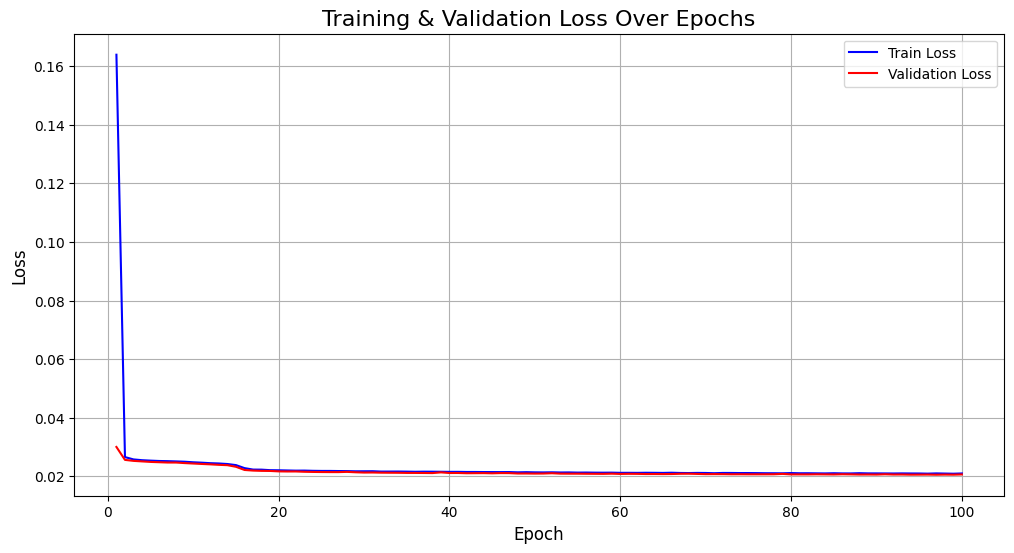

In [22]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [30]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/best_model_epoch_97.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AOD_pono_net().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")


===== 'pt/best_model_epoch_97.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:17<00:00,  7.15it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 18.1067 dB
테스트 데이터셋 평균 SSIM: 0.7035


이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


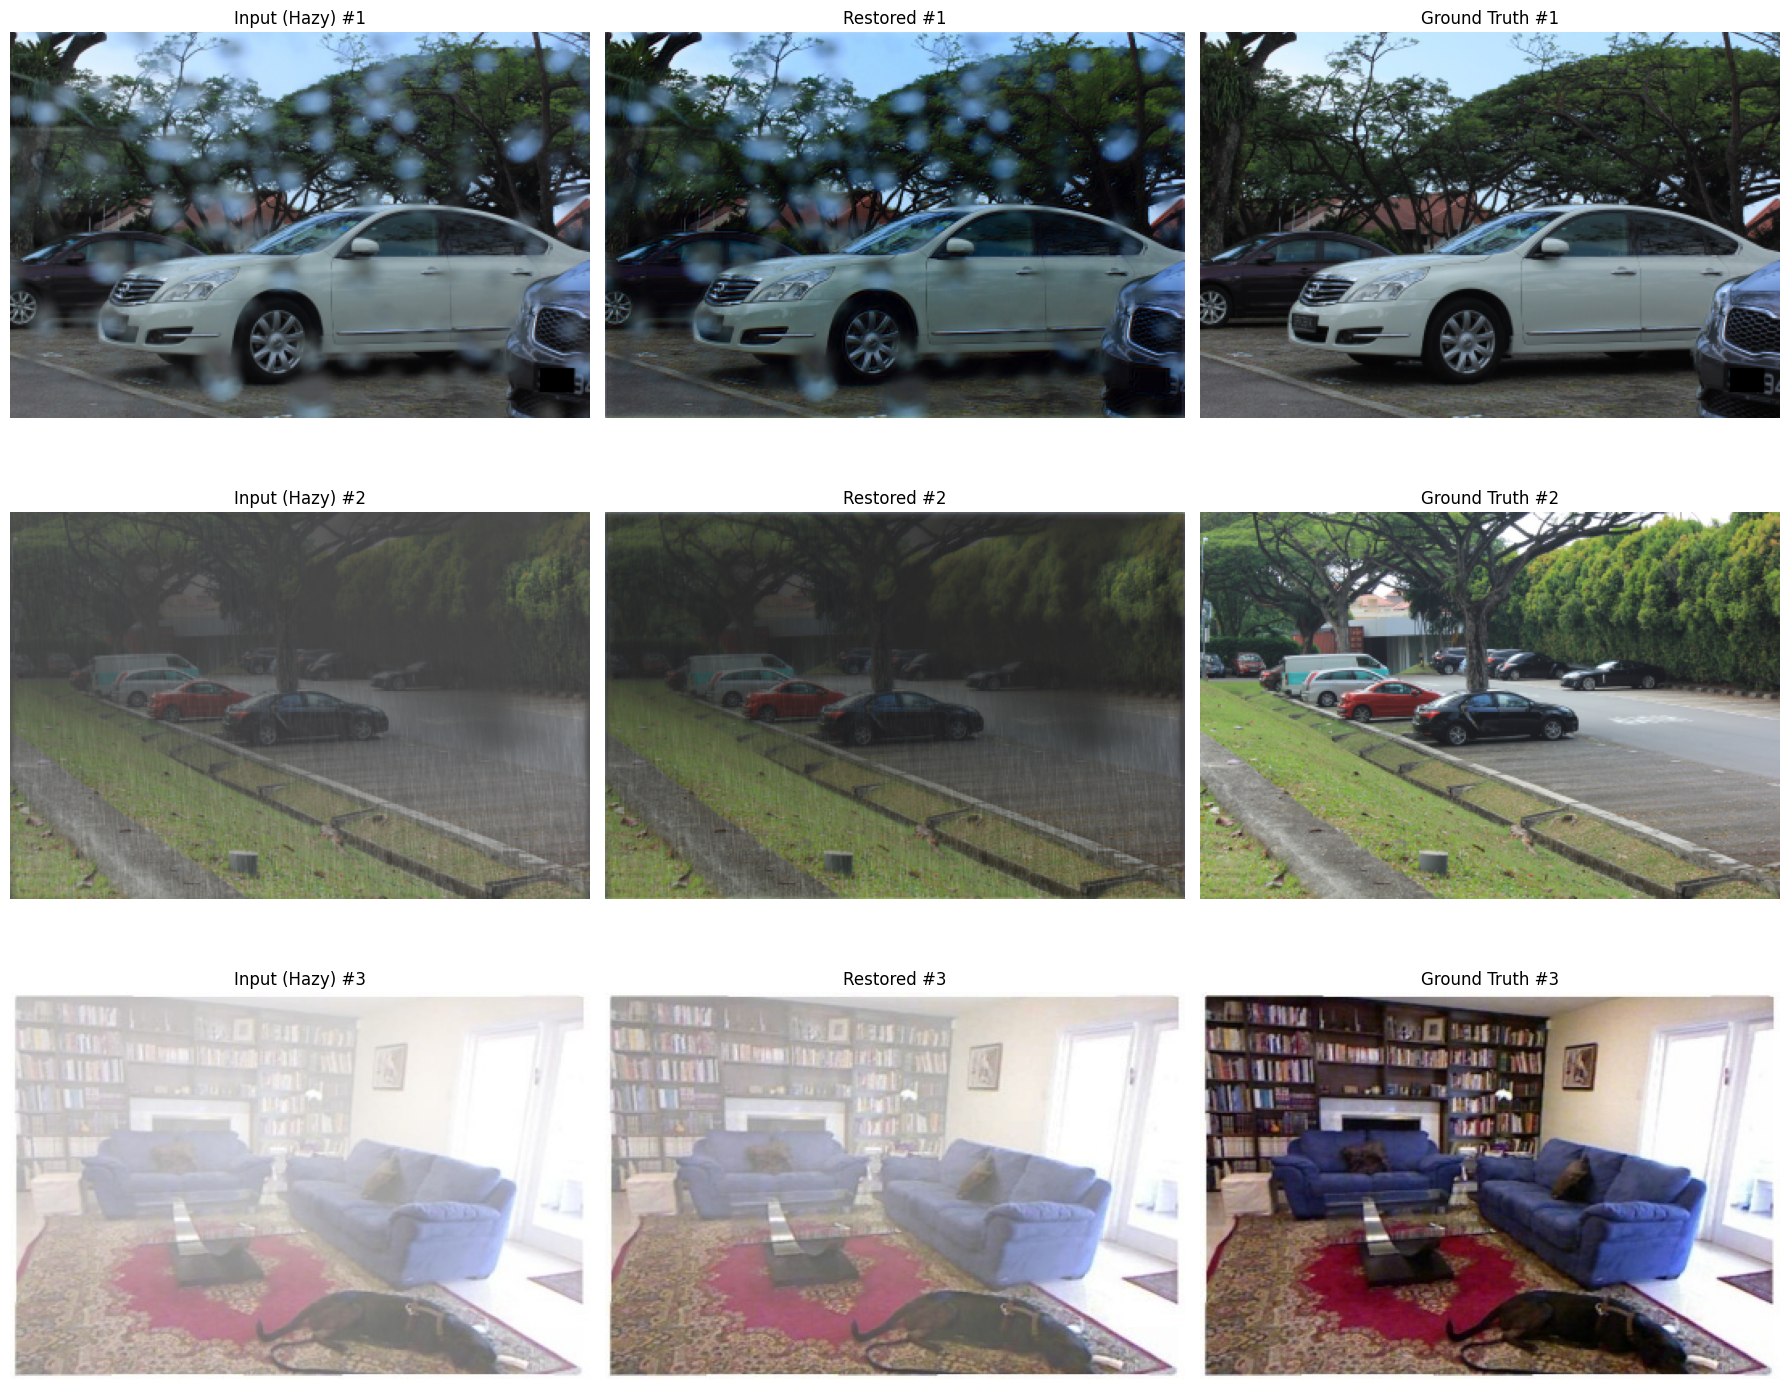


이미지 복원 및 비교 완료!


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/best_model_epoch_97.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AOD_pono_net().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [5]:
# onnx 변환용 셀
# pth_to_onnx.py
import torch

# 1. 모델 구조 불러오기 및 가중치 로드
model = AOD_pono_net()
model.load_state_dict(torch.load('./pt/aodNetPono/best_model_epoch_97.pth', map_location='cpu'))
model.eval() # 반드시 evaluation 모드로 설정!

# 2. 모델에 입력될 더미 데이터 생성 (중요!)
# 모델이 학습할 때 사용한 이미지 크기와 동일하게 맞춰주세요.
# 예: (배치크기, 채널, 높이, 너비)
dummy_input = torch.randn(1, 3, 360, 240) 

# 3. ONNX 파일로 변환
onnx_file_path = "aodnetpono.onnx"
torch.onnx.export(model,
                  dummy_input,
                  onnx_file_path,
                  export_params=True,
                  opset_version=11, # 호환성을 위해 버전을 명시하는 것이 좋음
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

print(f"모델이 {onnx_file_path} 파일로 성공적으로 변환되었습니다.")

C:\Users\zmffk\AppData\Local\Temp\ipykernel_5796\3333087363.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if k.size() != x.size():


모델이 aodnetpono.onnx 파일로 성공적으로 변환되었습니다.


In [1]:
# onnx_to_tflite.py
#

import tensorflow as tf
from onnx_tf.backend import prepare
import onnx

# 1. ONNX 모델 로드
onnx_model = onnx.load("aodnetpono.onnx")
tf_rep = prepare(onnx_model)

# 2. TensorFlow SavedModel 형식으로 임시 저장
save_path = "C:/temp/aodnetpono_tf_model"
tf_rep.export_graph(save_path)

# 3. TensorFlow Lite 변환기 생성
# converter = tf.lite.TFLiteConverter.from_saved_model("aodnet_tf_model") # 기존 코드
converter = tf.lite.TFLiteConverter.from_saved_model(save_path) # 변경된 코드

# 4. (강력 추천) 8비트 정수형으로 양자화하여 최적화
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 양자화를 위해 대표 데이터셋(representative dataset) 제공이 필요할 수 있습니다.
# 이는 모델이 실제 처리할 데이터의 분포를 알려주는 역할을 합니다.
# 예: 실제 안개 낀 이미지 100장을 전처리하여 사용
# def representative_data_gen():
#   for image in representative_dataset:
#     # 이미지를 모델 입력에 맞게 전처리 (리사이즈, 정규화 등)
#     processed_image = preprocess(image) 
#     yield [processed_image]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# 5. TensorFlow Lite 모델로 변환
tflite_model = converter.convert()

# 6. .tflite 파일로 저장
with open("aodnetpono_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!")

c:\Users\zmffk\OneDrive\바탕 화면\model\new-tf-env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\zmffk\OneDrive\바탕 화면\model\new-tf-env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

INFO:tensorflow:Assets written to: C:/temp/aodnetpono_tf_model\assets


INFO:tensorflow:Assets written to: C:/temp/aodnetpono_tf_model\assets


TensorFlow Lite 모델(aodnet_model.tflite) 변환 및 저장 완료!


In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image

# --- 1. TFLite 모델 로드 및 Interpreter 생성 ---
model_path = "./TFLITE/aodnetpono_model.tflite" 
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# --- 2. 모델의 입력 및 출력 정보 확인 ---
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("▼ Input Details")
print(input_details) # 예: [{'shape': array([  1,   3, 360, 480], dtype=int32), ...}]
print("\n▼ Output Details")
print(output_details)

# --- 3. (가장 중요) 입력 데이터 준비 ---
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

# ⭐️ 1. 리사이즈 방식 수정: (높이, 너비)가 아닌 (너비, 높이) 순서로 지정
# input_shape가 [1, C, H, W] 형식이므로 너비는 3번째, 높이는 2번째 인덱스입니다.
target_width = input_shape[3]
target_height = input_shape[2]

image_path = "dataset_split/test/input/51_rain.png" 
img = Image.open(image_path).resize((target_width, target_height))

input_data = np.array(img, dtype=input_dtype)
input_data = input_data / 255.0
input_data = np.expand_dims(input_data, axis=0) # 이 시점 모양: (1, 높이, 너비, 3)

# ⭐️ 2. 차원 순서 변경 (가장 중요!)
# 모델이 (1, 3, 높이, 너비) 형태를 기대하므로 차원 순서를 바꿔줍니다.
# (Batch, Height, Width, Channel) -> (Batch, Channel, Height, Width)
input_data = np.transpose(input_data, (0, 3, 1, 2))

# --- 4. 추론 실행 ---
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

## --- 5. 결과 확인 ---
# (이전 코드는 동일)
output_data = interpreter.get_tensor(output_details[0]['index'])

# 모델의 출력물(세로 360, 가로 240)을 이미지로 변환
output_image_data = np.transpose(output_data[0], (1, 2, 0))
output_image_data = (output_image_data * 255).astype(np.uint8)
result_image = Image.fromarray(output_image_data)

# ⭐️⭐️⭐️ 이 부분을 추가 ⭐️⭐️⭐️
# 모델 결과물을 원하는 크기(가로 360, 세로 240)로 리사이즈합니다.
desired_width = 360
desired_height = 240
final_image = result_image.resize((desired_width, desired_height), Image.Resampling.LANCZOS)

# 최종 리사이즈된 이미지를 저장합니다.
final_image.save("final_result_360x240.png")

print("\n▼ Inference Result")
print(f"모델 출력 shape: {output_data.shape}")
print(f"최종 저장 이미지 크기: {final_image.size}")
print("결과 이미지가 'final_result_360x240.png' 파일로 저장되었습니다.")

▼ Input Details
[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1,   3, 360, 240]), 'shape_signature': array([  1,   3, 360, 240]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

▼ Output Details
[{'name': 'StatefulPartitionedCall:0', 'index': 69, 'shape': array([  1,   3, 360, 240]), 'shape_signature': array([  1,   3, 360, 240]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

▼ Inference Result
모델 출력 shape: (1, 3, 360, 240)
최종 저장 이미지 크기: (360, 240)
결과 이미지가 'final_result_360x240.png' 파일로 저장되었습니다.
